## Tensorflow Probability - From Mixture Models to Hierarchical Models  

As I start to branch out into more interesting models, I have to wrap my head around more of tensorflow probability's syntax. My suspicion is that this is going to come back to understanding the shape of a distribution and making sure that we are handling this correctly.

So today, I am going to build this up slowly, piece-by-piece. I am going to put the eight schools problem aside for a day or two and focus on the code and "thought process" to implementing this in tfp. 

Please bear with me! I'll be taking this slowly and working my way up. If you, like me, are struggling with the tfp-approach (compared to Stan which I found immediately intuitive and well-documented), then this might be helpful to you as well :) 

**Plan of attack:** I am going ot begin by looking at **mixture models**, which seem like a natural precursor to hierarchical models to me. Then, I will return to the eight schools problem and attempt to extend what I learn from the mixture models to a meta-analysis. 

I will draw from a number of sources for this:  

  - Brendan Hasz's post on [Gaussian Mixture Models](https://brendanhasz.github.io/2019/06/12/tfp-gmm.html)  
  - TFP's [Multilevel Modeling Primer](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer.ipynb) which has some really nifty plate diagrams and some nice simple code  
  - Adam Haber's [Tutorial on Varying intercepts Models with Tensorflow Probability](https://adamhaber.github.io/2019/07/08/A-Tutorial-on-Varying-Intercepts-Models-with-TensorFlow-Probability.html). Haber's blog has been an amazing resource as I dive into tfp. He takes the time to explain *everything* which is great!

### Setup  

I'll be using the NoUTurn Sampler again. So I need to make sure I have tfp version 0.8.0 & will also make sure I have ArviZ and the daft packages.

In [1]:
! pip3 install -q --upgrade tensorflow-probability==0.8.0
! pip3 install -q arviz

     |████████████████████████████████| 2.5MB 3.5MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.8.0 which is incompatible.
ERROR: gym 0.15.3 has requirement cloudpickle~=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.
     |████████████████████████████████| 1.4MB 3.5MB/s 
     |████████████████████████████████| 4.1MB 42.4MB/s 
     |████████████████████████████████| 317kB 65.9MB/s 


In [0]:
import collections
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import daft as daft 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function

def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """

    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

def trace_fn(_, pkr):  
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
    )

def sampler(
    model = None,    # log-probability function
    nparams = None,  # number of parameters
    inits = None,    # initialisation for parameters
    trace_fn = None, # trace function
    iters = 2000,    # number of MCMC iterations
    warmup = 1000,   # warmup iterations
    chains = 1,
    bijectors_list = None):
  
  if not isinstance(inits, list):
    inits = [0.01] * nparams

  # I don't understand this part yet...
  # Dig into this in the future
  if bijectors_list is None:
    bijectors_list = [tfb.Identity()] * nparams

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
      tfp.mcmc.TransformedTransitionKernel(
          inner_kernel=tfp.mcmc.NoUTurnSampler(
              target_log_prob_fn = model,
              step_size=1.0
          ),
          bijector=[tfb.Identity()] * nparams
      ),
      target_accept_prob=.8,
      num_adaptation_steps=np.floor(0.5*warmup),
      step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
            inner_results=pkr.inner_results._replace(step_size=new_step_size)
        ),
      step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
      log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
  )

  samples, trace = tfp.mcmc.sample_chain(
      num_results = iters,
      num_burnin_steps = warmup,
      current_state = inits,
      kernel = kernel,
      trace_fn = trace_fn
  )

  return [samples, trace]

# compile the sampler
run_sampler = tf.function(sampler, autograph=False, experimental_compile=True)

## Mixture Models  

Brendan Hasz has written a [great blog post](https://brendanhasz.github.io/2019/06/12/tfp-gmm.html), with a whole lot of code and some nice explanations. I'll definitely be drawing from this, in addition to the tfp documentation for [categorical mixture models](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Mixture).  

First however, let's simulate some data. I am going to simulate two different datasets. The first will be simple two-dimensional gaussian clusters, the second will be univariate Poisson processes with 3 different rates.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


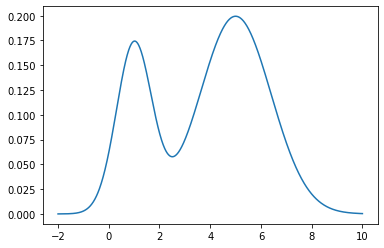

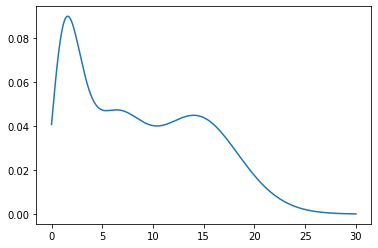

In [0]:
# Gaussian Clusters
pmix = 0.3
rv_gaussian_mixture = tfd.Mixture(
    cat = tfd.Categorical(probs = [pmix, 1.0 - pmix]), # mixing probabilities
    components=[
                tfd.Normal(loc=1.0, scale=0.7),
                tfd.Normal(loc=5.0, scale=1.4)
    ]
)
rv_poisson_mixture = tfd.Mixture(
    cat = tfd.Categorical(probs=[pmix, (1.0 - pmix)*0.4, (1.0 - pmix)*0.6]),
    components = [
                  tfd.Poisson(rate=2.0),
                  tfd.Poisson(rate=7.0),
                  tfd.Poisson(rate=15.0)
    ]
)
x = tf.linspace(-2., 10., 1000)
plt.plot(x, rv_gaussian_mixture.prob(x))
plt.show()

x = tf.linspace(0., 30., 1000)
plt.plot(x, rv_poisson_mixture.prob(x))
plt.show()


(10000,)


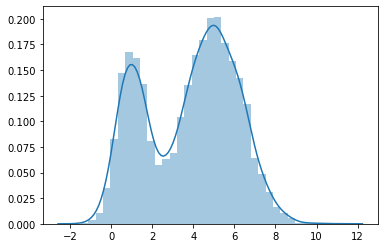

(10000,)


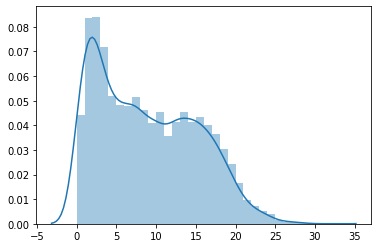

In [0]:
gaussian_mixture_ = rv_gaussian_mixture.sample(10000)
print(gaussian_mixture_.shape)
sns.distplot(gaussian_mixture_)
plt.show()

poisson_mixture_ = rv_poisson_mixture.sample(10000)
print(poisson_mixture_.shape)
sns.distplot(poisson_mixture_)
plt.show()

We've got two very different simulated datasets here to work with. The gaussian mixtures are pretty well separated, the Poisson mixtures less so. 

I was initially surprised by the shapes of these distributions. I was expecting them to have a shape of `(10000, k)`, where `k` is the number of components. This will be equivalent to the Gaussian distribution: `tfd.Normal(loc=[1.0, 5.0], scale=[0.7, 1.4])`. However, note that this isn't the case. These are univariate series which are drawn from `k` components, giving a shape of `(10000,)`. I don't know why I was surprised by this initially - this is the literal definition of a mixture distribution. I think I was just overthinking the tfp-angle on this and got myself a little twisted.

### Gaussian Mixture Model  

Let's begin with our Gaussian dataset and attempt to estimate the mean, standard deviation and mixing probabilities of our two components. For this, I have drawn more from the [Bayesian Gaussian Mixture Model](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb) tutorial than from Hasz's.

Our model is a two-component, 1-dimensional gaussian mixture model. It has the following structure:  

$$
y_i \sim Normal(\mu_{z_i}, \sigma_{z_i})  \\
z_i \sim Categorical(\theta) \\  
\mu_k \sim Normal(0, 5)  \\  
\sigma_k \sim HalfCauchy(0, 1) \\  
\theta \sim Dirichlet(2.0)
$$

In English (and reading from the bottom up):  

  - our two components, `k`, have a mixing probability, $\theta$, which must sum to one and for which we have defined a Dirichlet prior  
  - each of our mixture components, `k` have a mean, $\mu_k$, and variance, $\sigma_k$, with a standard normal and half-cauchy prior respectively  
  - every observation may arise from one of two categorical components. This "state membership" is $z_i$, parameterised by the mixing probabilities  
  - finally, our observations, $y_i$ arise from a Normal distribution with mean and variance corresponding to the sampled state, $z_i$, with corresponding mean and variance.  


The code is largely what we have seen before. All of "the magic" lies in the `joint_log-prob()` method. We will:  

  - define the priors for $mu$, $sigma$ and $theta$  
  - $z$ is not observed, it is represented by the `tfd.MixtureSameFamily` distribution that we have defined below  
  - note, that the commented block: `rv_observations = tfd.Mixture(...)` also works. I just prefer the simpler MixtureSameFamily. **However, this might be a good little trick for when I turn back to hierarchical modeling...**  
  - finally, we calculate and return the joint log likelihood   


In [0]:
reset_sess()

def joint_log_prob(observations, k, mu, sigma, theta):
  """
  Gaussian Mixture Model
  """

  # priors
  prior_mu = tfd.Normal(loc = tf.zeros(k), scale = 5.0)
  prior_sigma = tfd.HalfCauchy(tf.zeros(k), tf.ones(k))
  prior_theta = tfd.Dirichlet(2.0*tf.ones(k))

  # BOTH OF THESE WORK!
  rv_observations = tfd.MixtureSameFamily(
      mixture_distribution = tfd.Categorical(probs = theta),
      components_distribution = tfd.Normal(
          loc=mu,
          scale=sigma
      )
  )
  # rv_observations = tfd.Mixture(
  #   cat = tfd.Categorical(probs = theta), # mixing probabilities
  #   components=[
  #               tfd.Normal(mu[i], scale=sigma[i])
  #               for i in range(int(k))
  #   ]
  # )

  log_prob_components = [
      rv_observations.log_prob(observations),
      prior_theta.log_prob(theta)[..., tf.newaxis],
      prior_mu.log_prob(mu),
      prior_sigma.log_prob(sigma)
  ]
  sum_log_prob = tf.reduce_sum(tf.concat(log_prob_components, axis=-1), axis=-1)

  return sum_log_prob 

def unnormalised_posterior(mu, sigma, theta):
  return joint_log_prob(observations, k, mu, sigma, theta)


If our MCMC works correctly, we should be able to recover:  

  - the true mixing probability (0.3 for the lower component, 0.7 for the higher component)  
  - the mean and variance of the two components, (1, .7) and (5, 1.4) respectively

Let's run this! We'll simulate 200 observations from our mixture distribution and attempt to recover the parameters.

NOTE: the only "trick" here is defining `inits` properly. Each of the parameters require an initial state which the correct shape (in this case, they all have a shape of 2 corresponding to the number of components).

Instructions for updating:
The `logits` property will return `None` when the distribution is parameterized with `logits=None`. Use `logits_parameter()` instead.


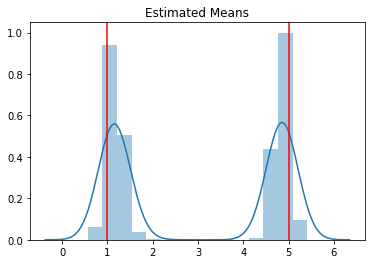

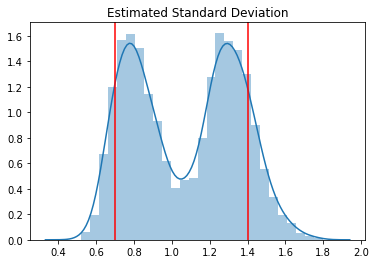

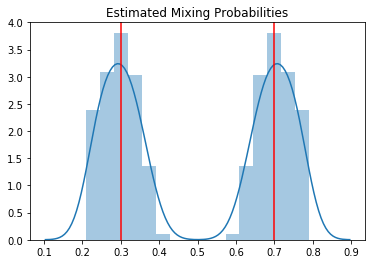

In [0]:
niter = 5000
nwarmup = 2000

[observations, k] = [rv_gaussian_mixture.sample(200), 2.0]
[mu_, sigma_, theta_], trace_ = run_sampler(
    model = unnormalised_posterior,
    nparams = 3,
    inits = [tf.ones(k), tf.ones(k), tf.ones(k)/k],
    trace_fn = trace_fn,
    iters=niter,
    warmup=nwarmup
)

# Plot the estimates
# mu
sns.distplot(tf.reshape(mu_, (np.prod(mu_.shape), )))
plt.axvline(x=1, color='red')
plt.axvline(x=5, color='red')
plt.title("Estimated Means")
plt.show()

#sigma
sns.distplot(tf.reshape(sigma_, (np.prod(sigma_.shape), )))
plt.axvline(x=0.7, color='red')
plt.axvline(x=1.4, color='red')
plt.title("Estimated Standard Deviation")
plt.show()

#theta
pmix_0 = np.array([x0 / (x0 + x1) for x0, x1 in theta_.numpy()])
thetas_ = np.array([pmix_0, 1 - pmix_0]).reshape(np.prod(theta_.shape),)
sns.distplot(thetas_)
plt.axvline(x=0.3, color='red')
plt.axvline(x=0.7, color='red')
plt.title("Estimated Mixing Probabilities")
plt.show()

These results are fantastic. The mean and mixing proportions are almost bang on (+/- some randomness due to randomness in our sampling). The standard deviations are slightly off, but I would expect these to improve with more data and a much longer chain. 

Let's quickly look at the trace plot to make sure that this looks reasonable:

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],1.162,0.173,0.850,1.485,0.061,0.045,8.0,8.0,8.0,37.0,NaN
mu[1],4.855,0.160,4.550,5.153,0.051,0.037,10.0,10.0,10.0,98.0,NaN
sigma[0],0.821,0.130,0.605,1.073,0.049,0.036,7.0,7.0,7.0,48.0,NaN
sigma[1],1.325,0.124,1.095,1.559,0.038,0.028,11.0,11.0,10.0,72.0,NaN
theta[0],2010.156,377.934,1367.071,2652.629,235.741,190.426,3.0,3.0,3.0,11.0,NaN
theta[1],4890.394,1154.445,3225.393,6745.107,1076.566,1156.086,1.0,1.0,1.0,20.0,NaN


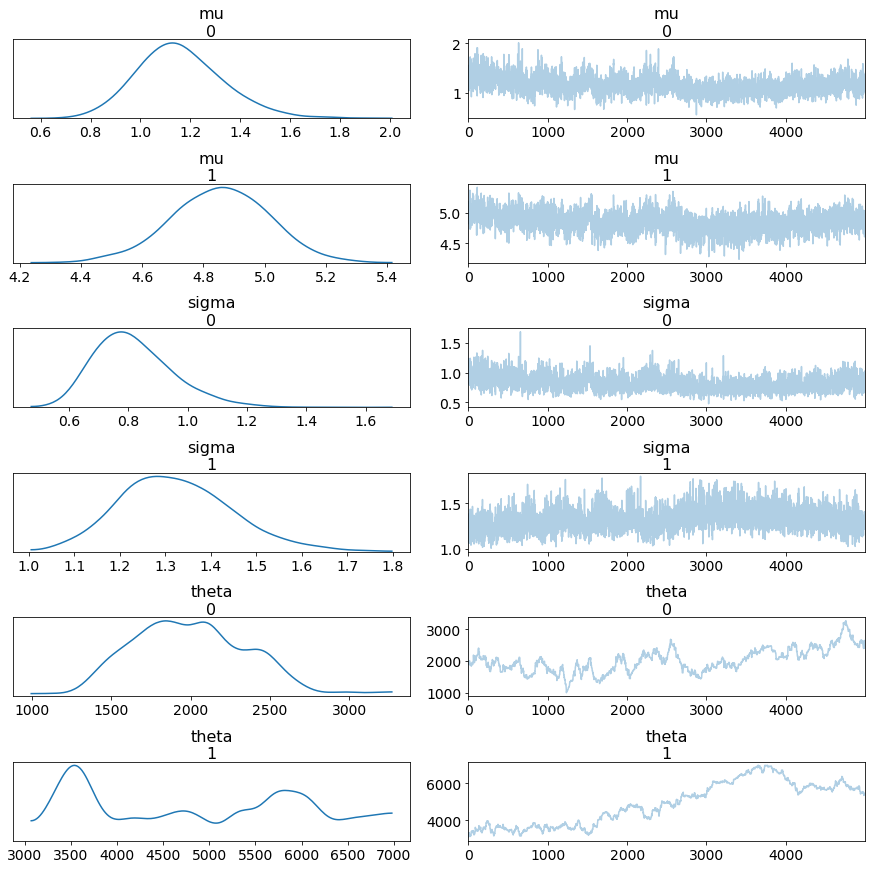

In [0]:
trace1 = az.from_tfp([mu_, sigma_, theta_], var_names = ["mu", "sigma", "theta"])
az.plot_trace(trace1)

az.summary(trace1)

The chains for $\mu$ and $\sigma$ look good. However $\theta$ is looking very very wrong - what's going on here?

The chains for $\theta$ look very dodgy and this is a clear sign that something has gone wrong here. I suspect that this is because $\theta_0$ and $\theta_1$ are directly correlated, causing our chains to go haywire. Because we only have 2 components, we only need to estimate a single mixing proportion. The second mixing proportion is simply the compliment of this.

Let's refactor our model appropriately. We'll change the prior on $\theta$ to by uniform and adjust the mixing probabilities in `rv_observations` to use this estimated $\theta$ and it's compliment. We will also need to change the initial value for $\theta$, let's set this at 0.5.

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],0.924,0.116,0.699,1.133,0.002,0.002,2195.0,2143.0,2246.0,2317.0,NaN
mu[1],4.693,0.166,4.381,5.004,0.005,0.003,1305.0,1305.0,1333.0,1772.0,NaN
sigma[0],0.633,0.093,0.461,0.798,0.002,0.001,2672.0,2551.0,2874.0,2859.0,NaN
sigma[1],1.520,0.128,1.291,1.765,0.003,0.002,1646.0,1618.0,1706.0,2187.0,NaN
theta,0.252,0.039,0.179,0.325,0.001,0.001,2783.0,2783.0,2789.0,3346.0,NaN


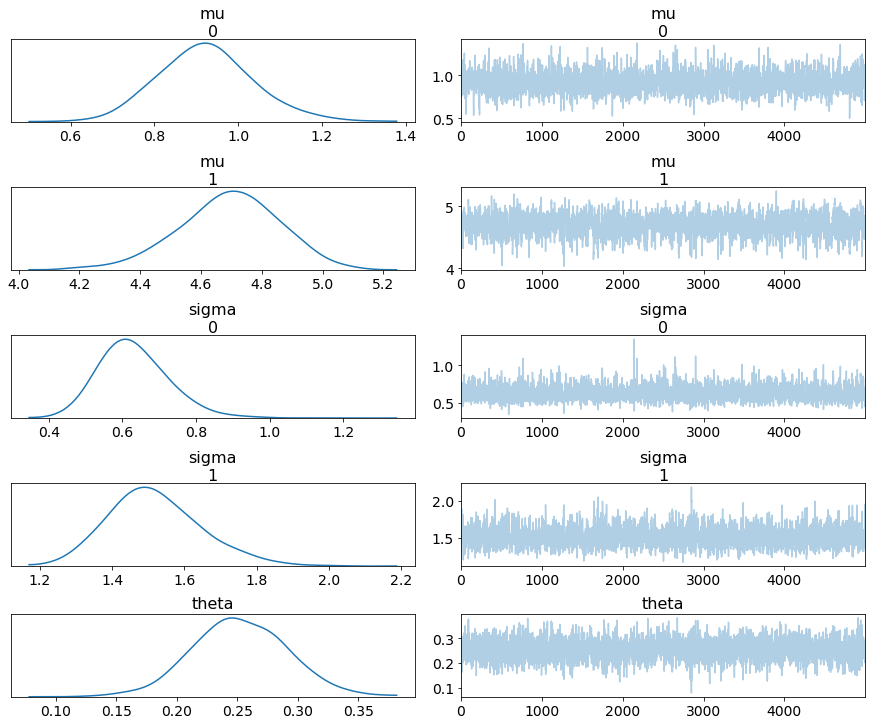

In [0]:
reset_sess()

def joint_log_prob(observations, k, mu, sigma, theta):
  """
  Gaussian Mixture Model
  """

  # priors
  prior_mu = tfd.Normal(loc = tf.zeros(k), scale = 5.0)
  prior_sigma = tfd.HalfCauchy(tf.zeros(k), tf.ones(k))
  prior_theta = tfd.Uniform(0.0, 1.0)

  rv_observations = tfd.MixtureSameFamily(
      mixture_distribution = tfd.Categorical(probs = [theta, 1 - theta]),
      components_distribution = tfd.Normal(
          loc=mu,
          scale=sigma
      )
  )

  log_prob_components = [
      rv_observations.log_prob(observations),
      prior_theta.log_prob(theta)[..., tf.newaxis],
      prior_mu.log_prob(mu),
      prior_sigma.log_prob(sigma)
  ]
  sum_log_prob = tf.reduce_sum(tf.concat(log_prob_components, axis=-1), axis=-1)

  return sum_log_prob 

def unnormalised_posterior(mu, sigma, theta):
  return joint_log_prob(observations, k, mu, sigma, theta)


niter = 5000
nwarmup = 2000

[observations, k] = [rv_gaussian_mixture.sample(200), 2.0]
[mu_, sigma_, theta_], trace_ = run_sampler(
    model = unnormalised_posterior,
    nparams = 3,
    inits = [tf.ones(k), tf.ones(k), 0.5],
    trace_fn = trace_fn,
    iters=niter,
    warmup=nwarmup
)

trace1 = az.from_tfp([mu_, sigma_, theta_], var_names = ["mu", "sigma", "theta"])
az.plot_trace(trace1)

az.summary(trace1)

That's much better - this looks much more reasonable. I am still not getting RHat values. I will dig into this one day.

### Poisson Mixture Model  

Hopefully, you can see where we are going with this. Estimating the Poisson model should be as simple as switching out the Normal distribution for a Poisson. That said, our Poisson components aren't as well separated as our Normal components... so I will also throw more data and longer chains at this.

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
gamma[0],14.397,0.481,13.458,15.268,0.066,0.047,54.0,54.0,55.0,633.0,NaN
gamma[1],3.963,1.152,1.504,5.553,0.137,0.097,71.0,71.0,81.0,25.0,NaN
gamma[2],2.223,1.666,0.611,6.021,0.766,0.579,5.0,5.0,2.0,15.0,NaN
theta[0],34962.625,8626.041,17128.201,47890.914,4448.172,3427.765,4.0,4.0,5.0,10.0,NaN
theta[1],22459.756,5553.298,13466.869,33213.887,1904.289,1414.563,9.0,8.0,9.0,11.0,NaN
theta[2],14368.859,5877.716,4750.236,23433.178,5249.564,5298.144,1.0,1.0,1.0,20.0,NaN


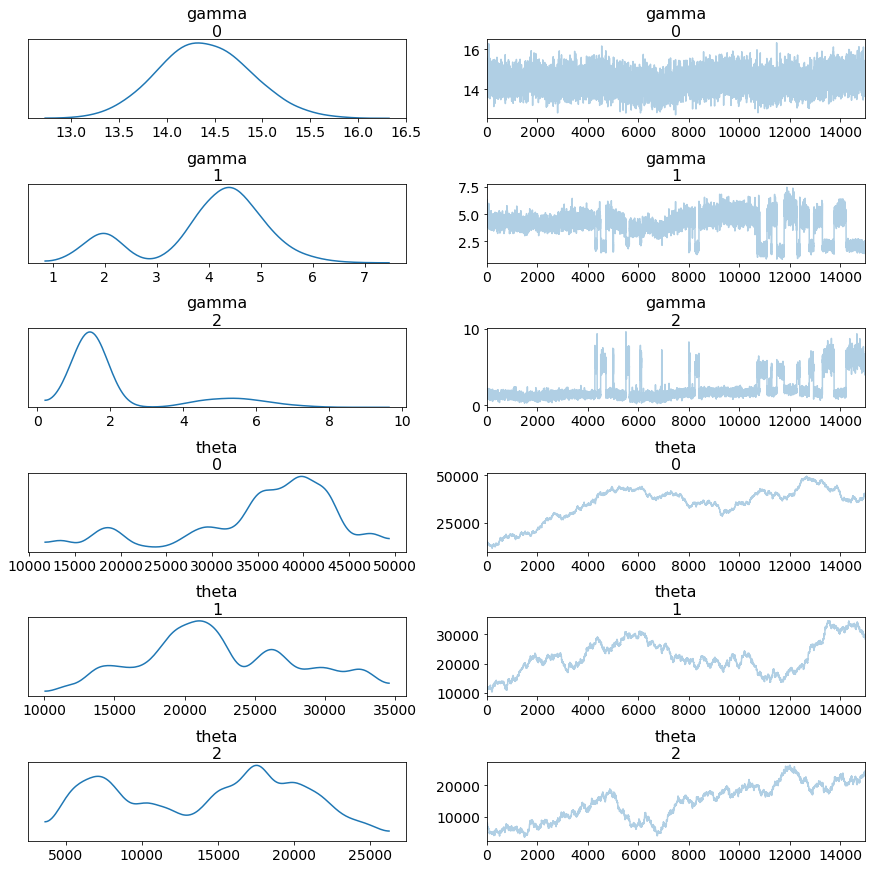

In [0]:
reset_sess()

def joint_log_prob(observations, k, gamma, theta):
  """
  Gaussian Mixture Model
  """

  # priors
  prior_gamma = tfd.HalfCauchy(tf.zeros(k), tf.ones(k))
  prior_theta = tfd.Dirichlet(2.0 * tf.ones(k))

  rv_observations = tfd.MixtureSameFamily(
      mixture_distribution = tfd.Categorical(probs = theta),
      components_distribution = tfd.Poisson(
          rate = gamma
      )
  )

  log_prob_components = [
      rv_observations.log_prob(observations),
      prior_theta.log_prob(theta)[..., tf.newaxis],
      prior_gamma.log_prob(gamma)
  ]
  sum_log_prob = tf.reduce_sum(tf.concat(log_prob_components, axis=-1), axis=-1)

  return sum_log_prob 

def unnormalised_posterior(gamma, theta):
  return joint_log_prob(observations, k, gamma, theta)


niter = 15000
nwarmup = 5000

[observations, k] = [rv_poisson_mixture.sample(200), 3.0]
[gamma_, theta_], trace_ = run_sampler(
    model = unnormalised_posterior,
    nparams = 2,
    inits = [tf.ones(k), tf.ones(k)/k],
    trace_fn = trace_fn,
    iters=niter,
    warmup=nwarmup
)

trace1 = az.from_tfp([gamma_, theta_], var_names = ["gamma", "theta"])
az.plot_trace(trace1)

az.summary(trace1)

Aha! Now we're seeing something interesting - the chains are flipping between states. This is a nice example of the problem of [identifiability](https://en.wikipedia.org/wiki/Identifiability). Michael Bentacourt has a good long post on [Identifying Bayesian mixture Models](https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html). There is also a nice little discussion about this on the [Stan Forums](https://discourse.mc-stan.org/t/identifiability-with-mixture-models/2640/3). 

The trick that Stan implements, is to simply order the estimates for each state, so that $\mu_1 > \mu_2 > ... > \mu_k$. But I can't find anything relating to this which is specific to tfp. I don't have a good solution for this at the moment. This will have to go on the "future efforts" list.


### Moving to Hierarchical Models  

Finally, let's go back to the Eight Schools problem and see if I can extend the ideas from these mixture models to a hierarchical meta-analysis. Whilst these aren't the same techniques, I think that the code syntax might share some similarities.

Let's begin with the fully-pooled version of the model - that is, we will assume that the treatment effects of all eight schools are from a common normal distribution:

$$
treatment\_effect \sim Normal(\theta, \sigma) \\ 
\theta \sim Normal(0, 100)
$$

Where $\theta$ is the mean of this "common normal distribution of treatments" and $\sigma$ is the standard error from each individual school. 

Here is our data:

In [3]:
schools = pd.DataFrame({
    'School': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
    'treatment': [28, 8, -3, 7, -1, 1, 18, 12],   # the estimated treatment effect
    'error': [15, 10, 16, 11, 9, 11, 10, 18] #standard error of treatment effect
})
schools

,School,treatment,error
0,A,28,15
1,B,8,10
2,C,-3,16
3,D,7,11
4,E,-1,9
5,F,1,11
6,G,18,10
7,H,12,18


And, we will define our model:

In [0]:
reset_sess()

def joint_log_prob(treatment, error, theta):
  """
  Fully-pooled Meta-analysis. We assume that the treatment
  effects arise from a common normal distribution, with
  mean 'theta'.

  Parameters:
  -----------
    @treatment: the reported treatment effect for each school
    @error: the reported standard error for each school
    @theta: the mean to be estimated
  """

  # prior for theta
  # This is almost an unreasonably wide prior :) 
  prior_theta = tfd.Normal(0, 100)

  # treatment model
  rv_treatment = tfd.Normal(theta, error)

  log_lik = (
      prior_theta.log_prob(theta) +
      tf.reduce_sum(rv_treatment.log_prob(treatment))
  )

  return log_lik 

def unnormalised_posterior(theta):
  return joint_log_prob(treatment, error, theta)

This model is about as simple as it comes. Gelman reported an estimated pooled treatment effect of [8 +/- 8], let's see if we get something similar:

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,7.575,4.147,-0.66,14.927,0.141,0.103,868.0,816.0,873.0,1297.0,NaN


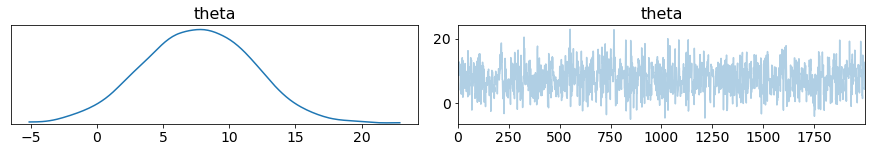

In [12]:
reset_sess()

# adjust the datatypes so that they're consistent across
# the tf graph
[treatment, error] = [
    tf.constant(schools.treatment, np.float32),
    tf.constant(schools.error, np.float32)
]

# Adjust `nparams` and `inits` appropriately
[theta_], trace_ = run_sampler(
    model = unnormalised_posterior,
    nparams = 1,
    inits = tf.constant(0.0),
    trace_fn = trace_fn
)

trace1 = az.from_tfp([theta_], var_names = ["theta"])
az.plot_trace(trace1)

az.summary(trace1)

Our estimates for theta are approx. 7.6 with a standard deviation of approx 4. This is very, very similar to what Gelman reported (mean = 7.7, standard deviation = 4), which he then rounded to [8 +/- 8]. So this is working nicely.

The model above is, perhaps, not an entirely reasonable model. The assumption that "all schools are equal" is a strong assumption. It is certainly restrictive and possibly, an unreasonable assumption. 

Ideally, we'd like to relax this assumption and allow for the possibility that one or more schools are not equal to the rest and that perhaps they arise from a different normal distribution. A fully-Bayesian hierarchical analysis allows for this.

Our model therefore, has to have more flexibility over the theta estimates. Instead of estimating a single value for theta, we will estimate a theta value *for every school*. And we will put a hierarchical prior over these theta estimates which will pool similar schools together. 

Our model will have the form:

$$
treatment_i \sim Normal(\theta_i, \sigma_i) \\ 
\theta_i \sim Normal(\mu, \tau) \\
\mu \sim Normal(0, 1) \\
\tau \sim HalfCauchy(0, 1)
$$

Above, $\mu$ and $\tau$ are our hierarchical priors.

**Estimation Part One - tfd.JointDistributionSequential**  
To begin with, I am going to break from my normal code-style and am going to draw from [Adam Haber's blog](https://adamhaber.github.io/2019/07/08/A-Tutorial-on-Varying-Intercepts-Models-with-TensorFlow-Probability.html) in which he demonstrates the use of `tfd.JointDistributionSequential`.

From Haber's blog:

"The main workhorse here is tfd.JointDistributionSequential, which is very similar to Sequential in Keras or PyTorch. It’s an object composed of list of Distribution-making functions (tfd.Distributions or Python callables that return a tfd.Distribution). The idea of sequentially stacking distributions, and adding the dependencies between them (the fact that the values sampled from tfd.Normal and tfd.Exponential are ‘fed’ into the 3rd distribution as its mean and standard deviation) is simple and intuitive, and fits nicely in the hierarchical modeling workflow; the code above is basically a 1-to-1 translation of the model specification."

This sequential processing is convenient, as it will allow us to directly encode the sampling flow that Gelman describes on pg 121 of BDA3: "we draw from the posterior distribution for the Bayesian model by simulating the random variables $\tau, \mu \ and \ \sigma$, in that order"

Thus, our model is:

In [0]:
m = tfd.JointDistributionSequential([
    
    # tau, mu, theta
    tfd.HalfNormal(50.0),            # tau
    tfd.Normal(0.0, 5.0),            # mu 
    lambda mu, tau: tfd.Sample(tfd.Normal(loc = mu, scale = tau), 
                               sample_shape = [schools.shape[0]]),

    # treatment 
    lambda theta: tfd.Independent(
        tfd.Normal(loc = theta, scale = error),
        reinterpreted_batch_ndims=1
    )

])

One of the very nice things about this style, is that it is very easy to sample from the prior distributions using the sample function:

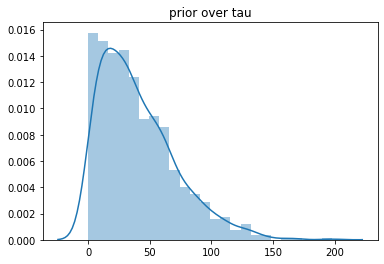

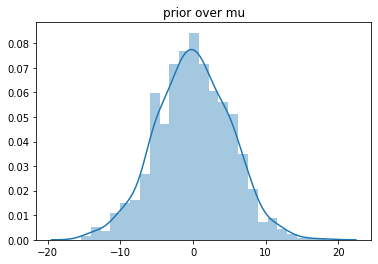

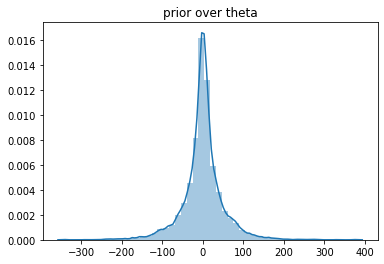

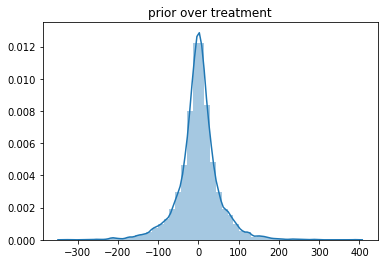

In [150]:
priors = m.sample(1000)
params = ['tau', 'mu', 'theta', 'treatment']

for x in range(4):
  sns.distplot(np.reshape(priors[x], (np.prod(priors[x].shape, ))))
  plt.title("prior over {}".format(params[x]))
  plt.show()

We can also use these prior samples as the initial states for our chains, which makes defining these a lot easier.

**Important note**: currently, my sampling method is only executing a single MCMC chain. So it is important that the `m.sample()` call below does not have a shape pased to it!

In the future, if you wanted to sample from four chains, you would call `m.sample(4)`. However, if you tried `m.sample(1)` right now, there is something wrong with my sampler and it doesn't sample.

In [151]:
init_tau, init_mu, init_theta, init_treatment = m.sample()

print([
       init_tau.shape,
       init_mu.shape,
       init_theta.shape,
       init_treatment.shape
])

[TensorShape([]), TensorShape([]), TensorShape([Dimension(8)]), TensorShape([Dimension(8)])]


So far so good, but we haven't yet defined our target log probability. This is nice and easy with this new syntax, so we'll do this inline below as we sample from our chains:

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau,6.692,5.218,0.455,15.877,0.201,0.142,673.0,673.0,297.0,98.0,NaN
mu,3.923,3.556,-2.749,10.388,0.112,0.079,1008.0,1008.0,1031.0,2352.0,NaN
theta[0],8.315,7.979,-4.568,24.904,0.221,0.156,1307.0,1307.0,943.0,3083.0,NaN
theta[1],5.310,5.961,-5.528,17.238,0.126,0.090,2241.0,2209.0,1718.0,5211.0,NaN
theta[2],2.923,7.228,-11.458,16.198,0.125,0.101,3343.0,2539.0,2952.0,3890.0,NaN
theta[3],4.876,6.187,-7.104,16.859,0.119,0.091,2695.0,2328.0,2329.0,4466.0,NaN
theta[4],2.562,5.811,-8.474,13.911,0.118,0.083,2438.0,2438.0,2231.0,4147.0,NaN
theta[5],3.264,6.273,-9.512,14.937,0.124,0.090,2567.0,2428.0,2060.0,4898.0,NaN
theta[6],8.081,6.697,-2.922,21.837,0.201,0.142,1114.0,1114.0,917.0,2686.0,NaN
theta[7],5.167,7.310,-8.728,19.923,0.144,0.104,2563.0,2464.0,1812.0,4037.0,NaN


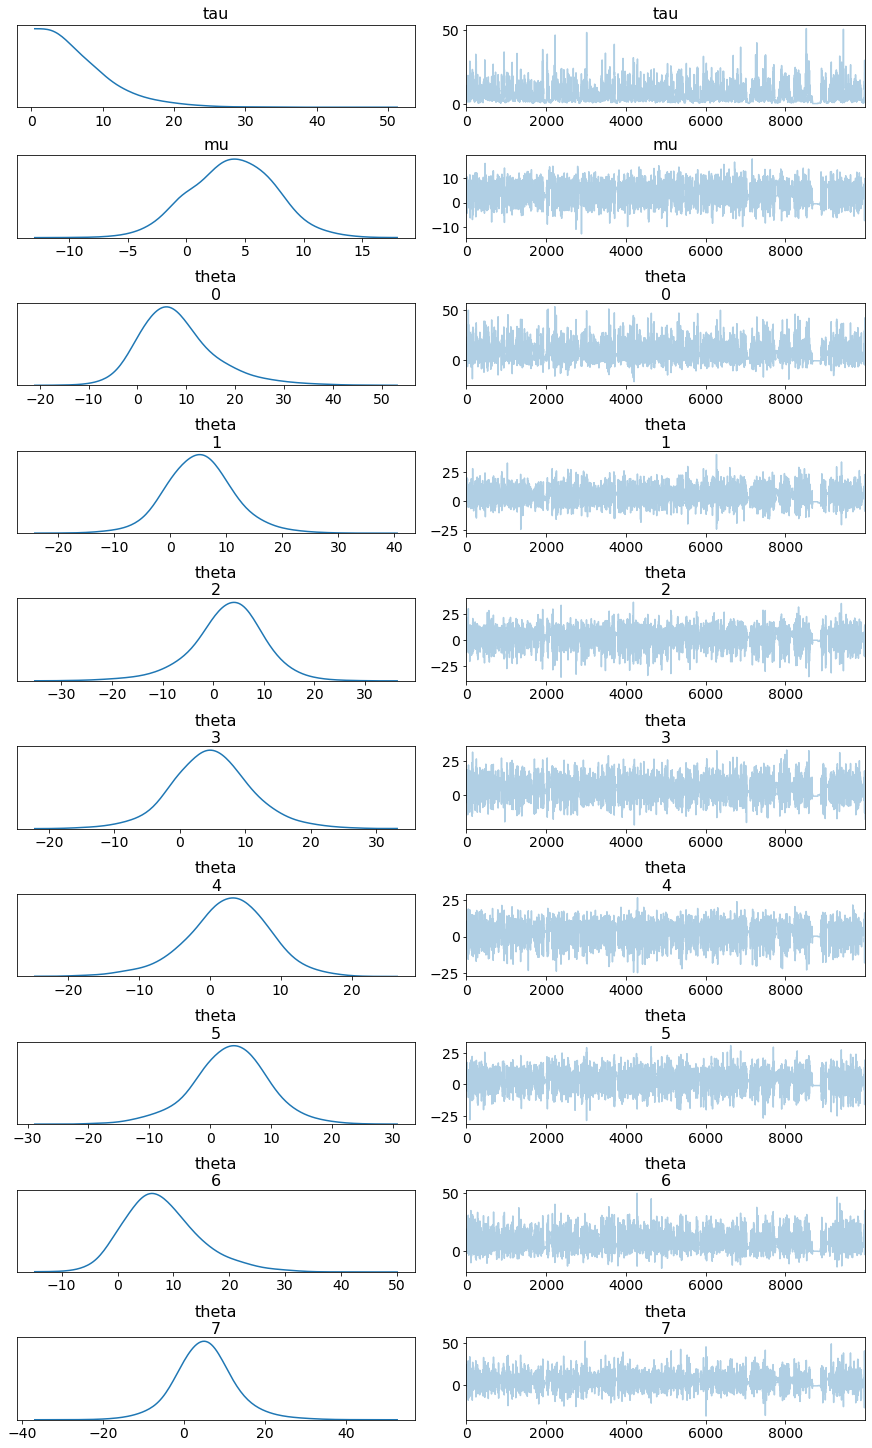

In [152]:
[treatment, error] = [
    schools.treatment.astype('float32'),
    schools.error.astype('float32')
]

[tau_, mu_, theta_], trace_ = run_sampler(
    model = lambda tau,mu,theta: m.log_prob([tau,mu,theta,treatment]),
    nparams = 3,
    inits = [
             init_tau, 
             init_mu,
             init_theta
    ],
    iters = 10000,
    warmup = 5000,
    trace_fn = trace_fn
)

trace1 = az.from_tfp([tau_, mu_, theta_], var_names = ['tau','mu','theta'])
az.plot_trace(trace1)

az.summary(trace1)

These are good results - and are reasonably consistent with the results reported by Gelman (see pp. 121 - 124 BDA3). Of note:  

  - our posterior distribution for $\tau$ is almost exactly like that reported by Gelman (see Fig 5.5, pg. 121, BDA3)  
  - our median estimates for $\theta$ are similar to Gelman's who reports: "the eight Bayesian 95% intervals largely overlap and are median-centered between 5 and 10" (p. 122, BDA3)  
  - the rank of $\theta$ are the same as reported by Gelman (see Table 5.3, pg. 123, BDA3)  

Any differences between our results are Gelman's will be due to the priors used. Try experimenting with the priors, and you will get quite different precisions for the estimates - though the posterior inferences are the same regardless of the prior.

## Final Thoughts  

I feel like I am starting to get somewhere with this now. The mixture models were quite easy to define (though it took me some experimentation to actually get the code to run). 

Using `JointDistributionSequential()` is a really interesting approach. I like this... I have been trying to approach tfp with a consistent style and approach - but the `JointdistributionSequential()` method is nice, clean and it really looks a lot like the specification of the model. In addition, I like that you can sample from the priors, this is a real bonus. Moving forwards, I think I will continue with this approach.

Massive thank you to Adam Haber for his blog posts! They have been incredibly helpful.